In [72]:
# Task 1: Data exploration and pre-processing

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV 
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_curve, roc_curve
from sklearn.preprocessing import RobustScaler
from sklearn.svm import SVC
from sklearn.inspection import permutation_importance
from sklearn.model_selection import GridSearchCV

data = pd.read_csv("heart.csv")

data.head() 
data.info()
data.describe()
data['output'].value_counts() # The output values are 1: chance of heart attack, or 0: no heart attack.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trtbps    303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalachh  303 non-null    int64  
 8   exng      303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slp       303 non-null    int64  
 11  caa       303 non-null    int64  
 12  thall     303 non-null    int64  
 13  output    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


output
1    165
0    138
Name: count, dtype: int64

In [13]:
# Task 1. Checking for null values 
print(data.isnull().sum())

# If there were null values, data.dropna() would have been used. 

#Checking for duplicates

#print(data.duplicated().sum()) # Since there is one duplicated value, we must drop it
data.drop_duplicates(inplace=True)

print(data.duplicated().sum()) # To double check that the duplicated value has been dropped, which it has been.

age         0
sex         0
cp          0
trtbps      0
chol        0
fbs         0
restecg     0
thalachh    0
exng        0
oldpeak     0
slp         0
caa         0
thall       0
output      0
dtype: int64
0


In [20]:
# Task 1. Dealing with outliers

# Calculate IQR for each numerical column
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1

# Define a threshold to identify outliers
threshold = 1.5

# Identify outliers
outliers = ((data < (Q1 - threshold * IQR)) | (data > (Q3 + threshold * IQR))).any(axis=1)

# Count the number of outliers
#print("Number of outliers:", outliers.sum()) # Number of outliers is 74, we have to drop these values!

# Drop outliers
data_no_outliers = data[~outliers]

# If you choose to drop outliers in place, you can use:
data.drop(data[outliers].index, inplace=True)

print("Number of outliers after dropping them:", outliers.sum()) # For double-checking

Number of outliers after dropping them: 0


In [125]:
# Task 1. Data description 

data.shape

(303, 14)

<Axes: xlabel='output', ylabel='count'>

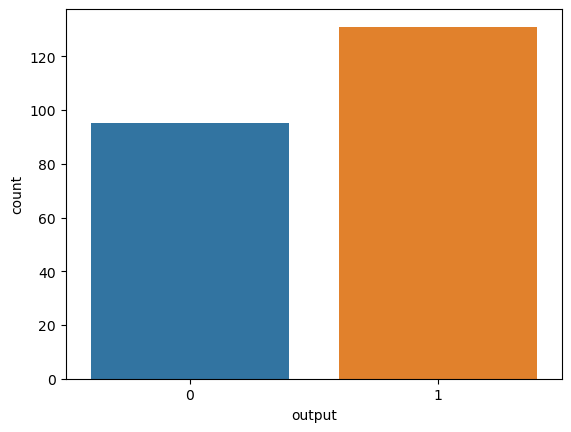

In [21]:
# Task 1. Using appropriate plots to visualize the data

sns.countplot(x = "output", data = data)

# It seems that the prediction of those with heart attack is more than those who don't have a heart attack.

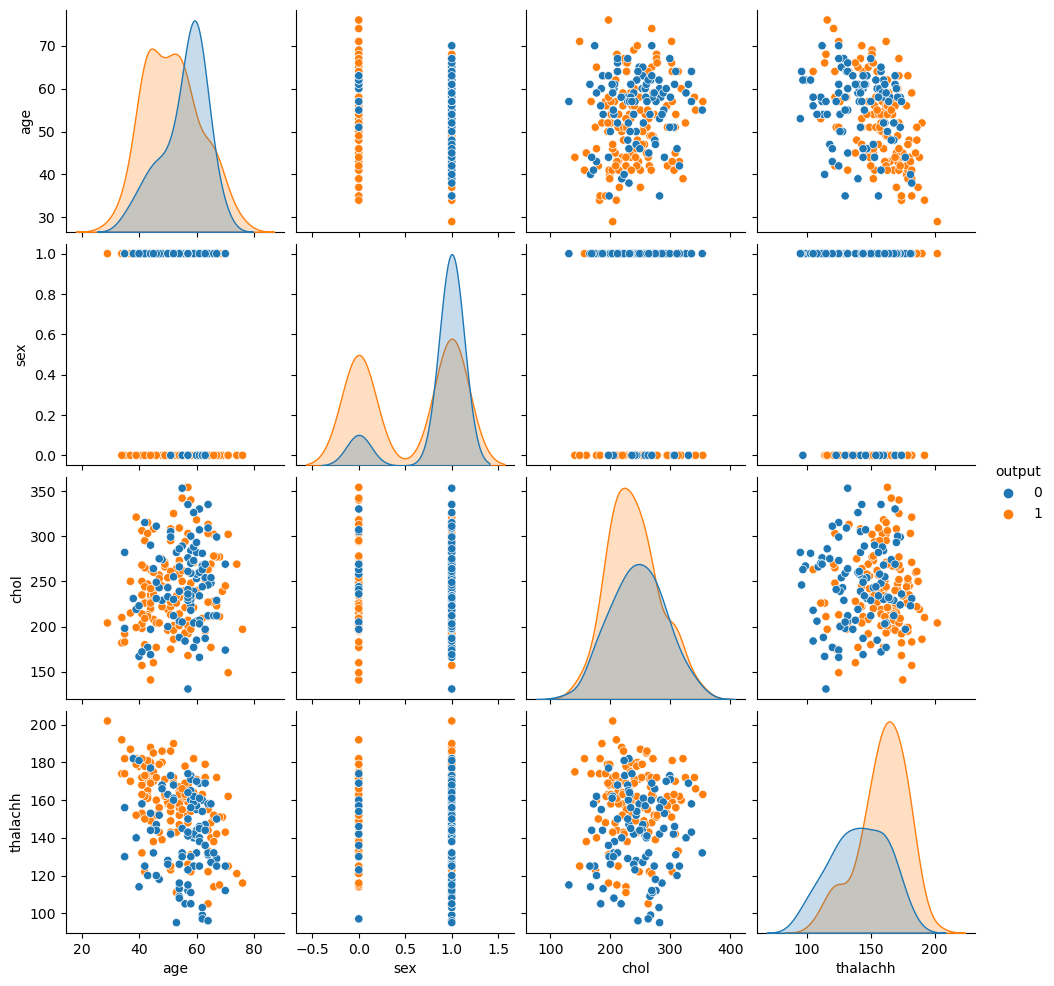

In [23]:
# Task 1. Using appropriate plots to visualize the data 2

sns.pairplot(data[["age", "sex", "chol", "output", "thalachh"]], hue = "output") 

# this shows the clustering of the output (0,1) across all features in the dataset.

In [131]:
# Task 2: Feature engineering 
# Feature importance 

feature_names=data.columns
feature_importance = pd.DataFrame(feature_names, columns=["feature"])
feature_importance = feature_importance.sort_values(by=['feature'], ascending=False)
feature_importance

,feature
3,trtbps
12,thall
7,thalachh
10,slp
1,sex
6,restecg
13,output
9,oldpeak
5,fbs
8,exng


In [107]:
# Task 2: Feature engineering 

categorical_features = ['sex', 'cp', 'fbs', 'restecg', 'exng', 'slp', 'caa', 'thall']
continuous_features = ['age', 'trtbps', 'chol', 'thalachh', 'oldpeak']

""""# Feature engineering technique: Handling skewed distributions
# Rationale: Since all continuous features are dispersed, it is our goal to make them about the same range"""

data_featured = data
# age
data_featured['age'] = pd.cut(data_featured['age'], bins=5, labels=range(5))
# resting blood pressure
data_featured['trtbps'] = pd.cut(data_featured['trtbps'], bins=5, labels=range(5))
# cholesterol
data_featured['chol'] = pd.cut(data_featured['chol'], bins=5, labels=range(5))
# maximum heart rate achieved
data_featured['thalachh'] = pd.cut(data_featured['thalachh'], bins=5, labels=range(5))

"""# Feature engineering technique: Encoding categorical features
# Rationale: so that each categorical variable will be replaced by a set of binary columns
#indicating the presence of absence of each category"""

data_featured = pd.get_dummies(data_featured, columns = categorical_features, drop_first = True) 

In [116]:
# Task 3: Machine learning model deployment (Logistic regression)

"""I chose classification to classify the outputs (1,0) to heart attack presence or absence.
Then for comparison sake, I will run SVM and see which model predicts heart attack presence with a higher accuracy"""

# Define the features and target (we will be working on the featured dataset first)

x = data_featured.drop(['output'],axis=1)
y = data_featured[['output']]

# Feature scaling
scaler = RobustScaler()
x[continuous_features] = scaler.fit_transform(x[continuous_features])

# Spliting the dataset into train and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.33, random_state = 42)

# Logistic regression classifier

clf = LogisticRegression()

# train the classifier
clf.fit(x_train, y_train)

# calculating the probabilities
y_pred_proba = clf.predict_proba(x_test)

# finding the predicted valued
y_pred = np.argmax(y_pred_proba,axis=1)

# printing the test accuracy
print("The test accuracy score of Logistic Regression Classifier is ", accuracy_score(y_test, y_pred)*100,"%")

The test accuracy score of Logistic Regression Classifier is  85.0 %


In [117]:
# Task 3: Machine learning model deployment (SVM)

model = SVC()
model.fit(x_train, y_train)
  
predicted2 = model.predict(x_test)
print("The test accuracy score of SVM is : ", accuracy_score(y_test, predicted2)*100, "%")

The test accuracy score of SVM is :  84.0 %


In [121]:
# Task 4: Model-evaluation and fine-tuning 

"""The algorithm with the higher accuracy turned out to be the logistic regression classifier,
with an accuracy of 85% in comparison to SVM which gave us an accuracy of 84%"""

# Evaluation metrics for Logistic regression classifier

y_true = y_test
y_pred = clf.predict(x_test)
print(classification_report(y_true, y_pred))

cm = confusion_matrix(y_test, y_pred)

print('Confusion matrix before optimization:\n\n', cm)

              precision    recall  f1-score   support

           0       0.83      0.81      0.82        42
           1       0.86      0.88      0.87        58

    accuracy                           0.85       100
   macro avg       0.85      0.84      0.85       100
weighted avg       0.85      0.85      0.85       100

Confusion matrix before optimization:

 [[34  8]
 [ 7 51]]


In [122]:
# Task 4: Model evaluation and fine-tuning 
"""To adjust hyperparameters, first we have to set parameter grid alongside C and penalty values to see which
value is most optimal for the model at hand"""

model_result_Hyperparameter=dict()

param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2']
}

lr=LogisticRegression()

grid_search=GridSearchCV(lr,param_grid,cv=5)
grid_search.fit(x_train,y_train)

print("Best hyperparameters: ", grid_search.best_params_)

y_pred=grid_search.predict(x_test)

print(accuracy_score(y_test,y_pred))
model_result_Hyperparameter["LogisticRegression"]=accuracy_score(y_test,y_pred)

best_model = grid_search.best_estimator_

# Predict on the testing dataset
y_pred = best_model.predict(x_test)

# Generate classification report
report = classification_report(y_test, y_pred)

# Print the classification report
print("Classification Report (after optimization):")
print(report)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Print the confusion matrix
print("Confusion Matrix (after optimization):")
print(conf_matrix)

Best hyperparameters:  {'C': 10, 'penalty': 'l2'}
0.86
Classification Report (after optimization):
              precision    recall  f1-score   support

           0       0.85      0.81      0.83        42
           1       0.87      0.90      0.88        58

    accuracy                           0.86       100
   macro avg       0.86      0.85      0.86       100
weighted avg       0.86      0.86      0.86       100

Confusion Matrix (after optimization):
[[34  8]
 [ 6 52]]


In [123]:
# Task 5: Deploy model on test dataset

y_pred = model.predict(x_test)

# Evaluate model performance
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix (test dataset):")
print(confusion_matrix(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.86      0.82        42
           1       0.89      0.83      0.86        58

    accuracy                           0.84       100
   macro avg       0.84      0.84      0.84       100
weighted avg       0.84      0.84      0.84       100

Confusion Matrix (test dataset):
[[36  6]
 [10 48]]


In [132]:
pip install streamlit


  Obtaining dependency information for streamlit from https://files.pythonhosted.org/packages/88/34/0751fd391fe90c8a90e70ef267080e0d461a2bf00c9e84c5a39d3389470d/streamlit-1.34.0-py2.py3-none-any.whl.metadata
  Obtaining dependency information for altair<6,>=4.0 from https://files.pythonhosted.org/packages/46/30/2118537233fa72c1d91a81f5908a7e843a6601ccc68b76838ebc4951505f/altair-5.3.0-py3-none-any.whl.metadata
  Obtaining dependency information for blinker<2,>=1.0.0 from https://files.pythonhosted.org/packages/bb/2a/10164ed1f31196a2f7f3799368a821765c62851ead0e630ab52b8e14b4d0/blinker-1.8.2-py3-none-any.whl.metadata
  Obtaining dependency information for cachetools<6,>=4.0 from https://files.pythonhosted.org/packages/fb/2b/a64c2d25a37aeb921fddb929111413049fc5f8b9a4c1aefaffaafe768d54/cachetools-5.3.3-py3-none-any.whl.metadata
  Obtaining dependency information for protobuf<5,>=3.20 from https://files.pythonhosted.org/packages/ad/6e/1bed3b7c904cc178cb8ee8dbaf72934964452b3de95b7a63412591ed